# Assigment 2: CAMSHIFT

Gruppe 2: Albrecht Oster, Linus Helfmann

## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

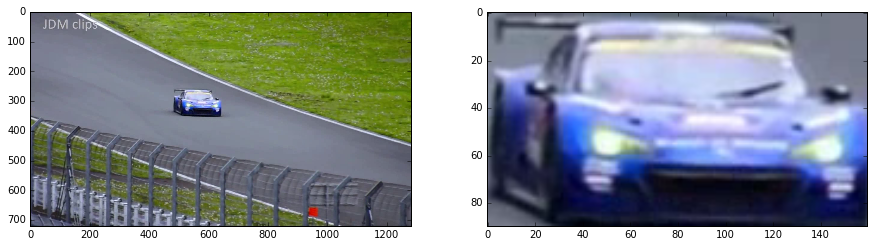

In [1]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt
# und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')

IMAGES_PER_ROW = 4

MIN_SATURATION_CAR = 0.2
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20

image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.imshow(image)
ax2.imshow(imageCar)

def binNr(nbins, hue):
    return int(round((hue*nbins)%nbins)) % nbins


def createColorHistogram(img, binCount = 256, out = plt):
    img_hsv = color.rgb2hsv(img)
    bins = np.zeros(binCount)
    # ...
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            value = binNr(binCount,img_hsv[y,x,0])
            bins[value] = bins[value] +1 
    out.bar([int(round(360.0*(x+0.5)/binCount)) for x in range(binCount)],bins)
    return bins


* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


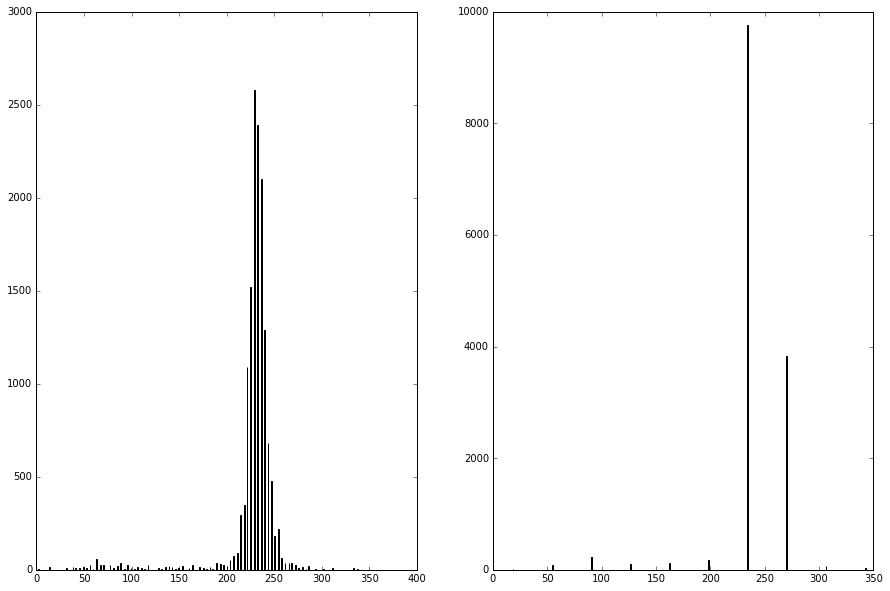

In [2]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
    
histCar100 = createColorHistogram(imageCar, 100, ax1)
histCar10 = createColorHistogram(imageCar, 10, ax2)

## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

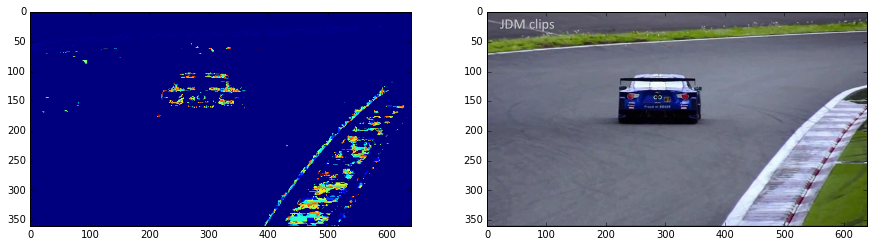

In [3]:
# Tip: in der Nacht sind alle Katzen grau ;)
def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    maxprob = max(objectHist)
    img_hsv = color.rgb2hsv(image)
    
    new_image = np.zeros(image.shape[0:2])
        
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            hsv = img_hsv[y,x]
            number = binNr(nbins, hsv[0])
            if hsv[1] >= minSaturation and hsv[2] >= minValue:
                new_image[y,x] = objectHist[number] / maxprob
    return new_image

    
nbins = 250
lastFrame = io.imread('images/racecar/151.jpeg')
histogramCar = createColorHistogram(imageCar, nbins, ax1)
probDistr = createProbDistribution(lastFrame, histogramCar, nbins, \
                                   MIN_SATURATION_CAR, MIN_VALUE_CAR)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(probDistr)
ax2.imshow(lastFrame)

### ROI auf Bild anzeigen


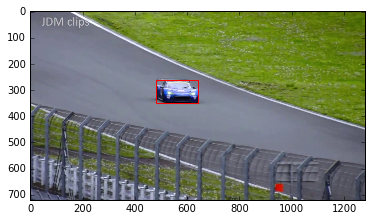

In [4]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="red"
        )
    )
    
    out.imshow(image)

drawROI(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpeg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

In [5]:
#Bilder laden (Tacos)
import os

path = 'images/taco/'
images = []
for file in sorted([path + f for f in os.listdir(path)]):
    images.append(io.imread(file))

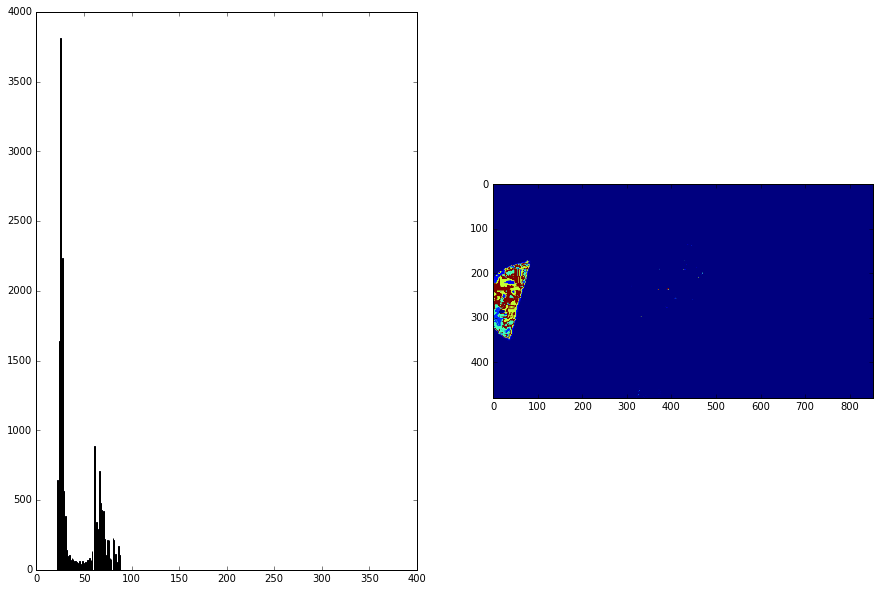

In [6]:
# Taco 1 test
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

xmin = 0
xmax = 100
ymin = 180
ymax = 344
nbins = 250
taco = images[0][ymin:ymax, xmin:xmax]
histogramTaco = createColorHistogram(taco, nbins, ax1)
probDistrTaco = createProbDistribution(images[0], histogramTaco, nbins, \
                                       MIN_SATURATION_TACO, MIN_VALUE_TACO)
ax2.imshow(probDistrTaco)

In [7]:
def createProbDistrForTaco(image):
    return createProbDistribution(image, histogramTaco, nbins, \
                                  MIN_SATURATION_TACO, MIN_VALUE_TACO)

# Alle Bilder berechnen
from multiprocessing import Pool as ThreadPool 
pool = ThreadPool(4)
probDistrTacos = pool.map(createProbDistrForTaco, images)

In [8]:
def moments(image, exp_x, exp_y):
    m = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            m += x**exp_x * y**exp_y * image[y,x]
    return m

def findMean(prob,x,y,width,height):
    field = prob[y:y+height,x:x+width]
    m00 = moments(field,0,0)
    m01 = moments(field,0,1)
    m10 = moments(field,1,0)
    return (max(0,int(x+(m10/m00)-(width/2))), int(y+(m01/m00)-(height/2)))
    
def findROI(prob,x,y,width,height):
    while True:
        (newx, newy) = findMean(prob,x,y,width,height)
        if abs(x-newx) < 1 and abs(y-newy) < 1:
            break
        x, y = newx, newy
    return (newx,newy)

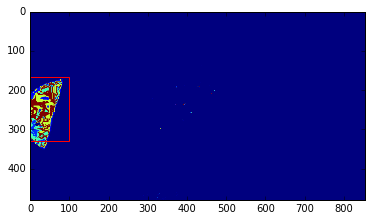

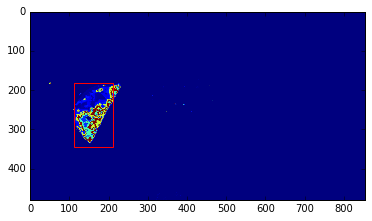

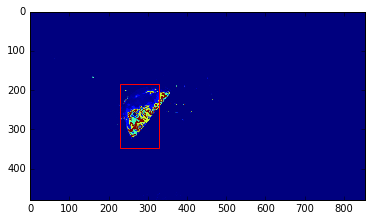

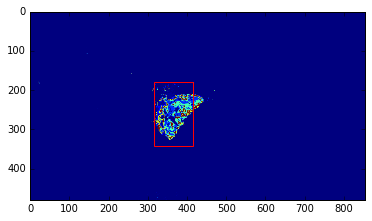

In [9]:
#Für alle Bilder MeanShift berechnen

x = xmin
y = ymin
width = xmax-xmin
height = ymax-ymin
points = []
codes = []

for i in range(0,len(probDistrTacos)):
    prob = probDistrTacos[i]
    (x,y) = findROI(prob,x,y,width,height)
    points.append((int(x+(width/2)), int(y+(height/2))))
    codes.append(patches.Path.LINETO)
    
    
    # nur jedes 60. Bild zeichnen
    if i % 60 == 0:
        ax = plt.subplot()
        ax.imshow(prob)
        rect = patches.Rectangle((x, y), width, height, linewidth=1, \
                                     edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
codes[0] = patches.Path.MOVETO

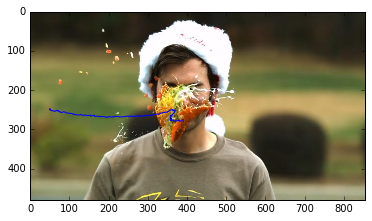

In [10]:
# Pfad über alle Bilder ausgeben

ax = plt.subplot()
ax.imshow(images[-1])

path = patches.Path(points, codes)
patch = patches.PathPatch(path,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(patch)

plt.show()

##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)